# <center>Practical 09: Coding Exercise (6pts)</center>

<p style="color:#0000FF";> <b>Lets first make sure that all the required dependencies are installed</b></p> 

### With pip (in your local machine)
1. Open Anaconda prompt
2. Type ``pip install gym``
3. If pip is missing, type ``conda install pip``
4. If using a GPU, type ``pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html``
5. If using a CPU, type ``pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html``

### In AWS
1. Add and execute the following line at the beginning of your notebook
```python 
import sys
!{sys.executable} -m pip install gym```
2. Kernels with ``torchvision`` and ``pytorch`` are already installed and ready to be used
3. Go to ``Kernel -> Change kernel`` and select ``conda_pytorch_latest_p36``

# CartPole Environment

In this notebook, we will DQN to solve the Cart-Pole environment.

<img src="Support/images/cartPole.gif" height="400" width="400" align="center">

## State Space
The state space of this environment is defined by a 4-tuple where each value represents:

<img src="Support/images/cartPole_actionSpace.png" height="400" width="400" align="center">

## Action Space
There are just two possible discrete actions

<table>
<thead>
<tr>
<th>Num</th>
<th>Action</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Push cart to the left</td>
</tr>
<tr>
<td>1</td>
<td>Push cart to the right</td>
    </tr>
</table>

## Rewards

Reward is 1 for every step taken, including the termination step

## Other Considerations
- When choosing the starting state, all observations are assigned a uniform random value in [-0.05..0.05]
- An episode is considered as terminated if:
    - Pole Angle is more than 12 degrees.
    - Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
    - Episode length is greater than 200.
    
    
**The environment is considered to be solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.**

In [ ]:
#import sys
#!{sys.executable} -m pip install gym

In [1]:
# Import all required dependencies

import gym
import math
import random
import numpy as np
from collections import namedtuple
import copy
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 


import matplotlib.pyplot as plt
%matplotlib inline

import io
import base64
from IPython.display import HTML
from IPython.display import clear_output

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RUN_TRAINING = False

     |████████████████████████████████| 1.6 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 69.7 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654654 sha256=81f4ce6a2f3aed0ea0577e404eb1873dd0c98a58626ae072b59b707d7ff84850
  Stored in directory: /home/ec2-user/.cache/pip/wheels/95/b0/62/af38051b97354eab5b2ff9a5fb92f5015a480745568c91e0b0
Successfully built gym
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


## DQN Algorithm

With a random policy, the cart pole behaves as shown below and obtains a reward of 13 points

Let's use Deep Q-learning with replay memory and target action-value network to improve the performance of the cart pole

In [2]:
video = io.open('Support/images/randomPolicy.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

You are tasked with extending the DQN with Replay Memory implementation seen in class to the algorithm shown below

<img src="Support/images/DQN_algorithm.png" width="600" height="600" align="center">


**What to do**

To do so, you must mainly restructure the Agent class in the following way:
- Extend the Agent class' attributes to include 2 DQN networks instead of one (one target and a=one policy network)
- Change the method ``get_next_q(.)`` so the q-values are computed using the target network instead of the policy network
- Complete the ``transfer_parameters``(.). This method replaces the parameters of the target network with those of the policy network. Use the pytorch ``load_state_dict(.)`` and ``state_dict()`` to do this
- In the main loop, include instructions that call ``transfer_parameters``(.) after a predefined number of episodes

You should also add the missing steps in the ``optimize(.)`` method of the Agent class. These steps were covered during class:

- Complete the computation of the target value. Use the variables ``non_final_mask`` and ``non_final_next_states`` to do so.
- Compute the loss. That is the difference between the target q-values (``expected_q``) and the values estimated by the network (``predicted_q``). Use the attribute ``self.loss_fn(.)``.

### Replay Buffer

Let's first define our representation of the replay buffer. To do so, we will use the class ``ReplayMemory`` shown below

In [3]:
# This tuple represents one observation in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    """
    A cyclic buffer of bounded size (capacity) that holds the transitions 
    observed recently. 
    
    It also implements a sample() method for selecting a random 
    batch of transitions for training.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Returns a minibatch of `Transition` randomly
        Args:
            batch_size (int): Size of mini-bach
        Returns:
            List[Transition]: Minibatch of `Transition`
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Returns the length """
        return len(self.memory)

### DQN Network

Let us now define the Multi Layer Perceptron network that will be used as the function approximator for the action-value function (q-function)

In [4]:
class DQN(nn.Module):
    """DQN Network
        Args:
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
    """
    def __init__(self, num_inputs=4, num_actions=2, hidden_dim=128):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        )
        
    def forward(self, x):
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, num_actions)
        """
        return self.layers(x)

### DQN Agent

This class contains the main steps of the Deep Q-learnig algorithm.


In [5]:
class DQNAgent(object):
    """DQN Agent
    This class contains the main steps of the DQN algorithm
    
    Attributes:
    policy_net (DQN): Function approximator for our target q function
    loss_fn (MSELoss): Criterion that measures the mean squared error (squared L2 norm) 
                       between each element of the predicted and target q-values.
    optimizer (Adam): Stochastic gradient optimize
    gamma (float): Discount factor
    """
    
    def __init__(self, seed=123, input_dim=4, output_dim=2, 
                 hidden_dim=128, gamma=0.99):
        """
        Define instance of DQNAgent
        Args:
        seed (int): Value used to initialize random number generator
        input_dim (int): `state` dimension.
        output_dim (int): Number of actions.
        hidden_dim (int): Hidden dimension in fully connected layer
        """
        torch.manual_seed(seed)
        self.policy_net = DQN(input_dim, output_dim, hidden_dim).to(device)
                
        # TODO 1: Add a target network. Make sure both networks start with same parameters
        self.target_net = DQN(input_dim, output_dim, hidden_dim).to(device)
        
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
                
        self.gamma = torch.tensor(gamma).float().to(device)
        
    def get_action(self, state, action_space_dim, epsilon):
        """
        Select next action using epsilon-greedy policy
        Args:
        epsilon (float): Threshold used to decide whether a random or maximum-value action 
                         should be taken next
         Returns:
            int: action index
        """        
        with torch.no_grad():
            cur_q = self.policy_net(torch.from_numpy(state).float().to(device))
        q_value, action = torch.max(cur_q, axis=0)
        action = action if torch.rand(1,).item() > epsilon else torch.randint(0, action_space_dim, (1,)).item()
        action = torch.tensor([action]).to(device)
        return action
    
    def get_next_q(self, state):
        """Returns Q_value for maximum valued action at each state s
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, num_inputs)
        Returns:
            torch.Tensor: Q_value, 1 tensor of shape (n)
        """
        with torch.no_grad():
            # TODO 2: Predict q-value using target network
            next_q = self.target_net(state)
        q, _ = torch.max(next_q, axis=1)
        return q
    
    def optimize(self, batch):
        """Computes `loss` and backpropagation
        Args:
            batch: List[Transition]: Minibatch of `Transition`
        Returns:
            float: loss value
        """
        
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)
        next_state_batch = torch.stack(batch.next_state)
                
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state is the one after which the simulation ends)
        non_final_mask = torch.tensor(tuple(map(lambda s: s.item() is not True,
                                          batch.done)), device=device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for i, s in enumerate(batch.next_state)
                                            if batch.done[i].item() is not True])

        # Compute predicted q-values
        predicted_q = self.policy_net(state_batch).gather(1, action_batch).reshape(1,-1)
        
        # TODO 3: Compute expected values for non-terminal and terminal states (this is our TD target)
        target_q = torch.zeros(len(batch.state), device=device)
        target_q[non_final_mask] = self.get_next_q(non_final_next_states)
        expected_q = reward_batch.reshape(1,-1)+(self.gamma * target_q)
        
        # TODO 4: Compute loss 
        loss = self.loss_fn(expected_q, predicted_q)
        
        # Use loss to compute gradient and update policy parameters through backpropagation
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
                
        return loss.item()
    
    def transfer_parameters(self):
        # TODO 5: Complete parameter transfer from policy to target network
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [6]:
def plot(frame_idx, rewards, losses):
    """
    Plot evolution of rewards and losses during training
    Args:
         rewards (list): Cummulative rewards for episodes seen so far
         losses (list): Prediction error at each training step
    
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episodes %s.\nCummulative reward last 10 episodes: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.ylabel("Avg. cummulative reward")
    plt.xlabel("No. of episodes")
    plt.subplot(132)
    plt.title('MSE Loss')
    plt.ylabel("Avg. cummulative reward")
    plt.xlabel("No. of steps")
    plt.plot(losses)
    plt.show()

### Running Parameters

The parameter ``freq_sync`` defines how often parameters are transferred between networks. 

In [7]:
# Define running hyper-parameters and epsilon training sequence

memory_capacity = 1000
batch_size = 62
env_name = "CartPole-v0"
num_episodes = 1500
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 200
gamma = 0.99
hidden_dim = 128
freq_sync = 10

epsilon_by_step = lambda frame_idx: epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * frame_idx / epsilon_decay)


### Main Loop and Replay Buffer Control

This is the main loop of our DQN implementation. Here we generate the samples added to the replay memory and train the agent using a batch sampled for the replay memory

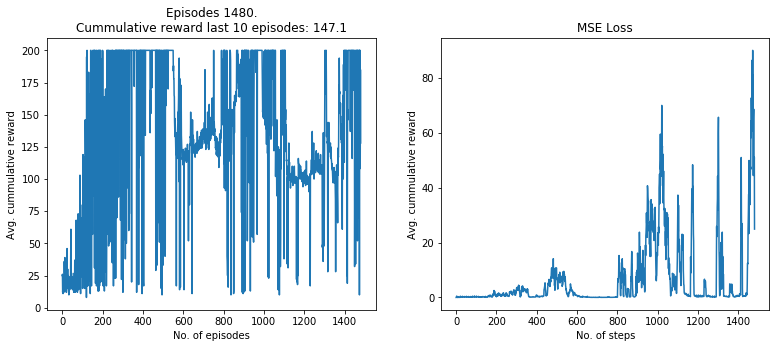

In [9]:
losses_list, rewards_list, episode_len_list = [], [], []
list_epsilon = []
replay_buffer = ReplayMemory(memory_capacity)

env = gym.make(env_name)
n_actions = env.action_space.n
dim_state = env.observation_space.shape[0]

agent = DQNAgent(seed=1234, input_dim=dim_state, 
                 output_dim=n_actions, 
                 hidden_dim=hidden_dim)

cur_epsilon = epsilon_start

if RUN_TRAINING:
    for i_episode in range(num_episodes):

        state, done, ep_len, losses, rewards = env.reset(), False, 0, 0, 0

        cur_epsilon = epsilon_by_step(i_episode+1)
        list_epsilon += [cur_epsilon]
        while not done:
            ep_len += 1
            action = agent.get_action(state, n_actions, cur_epsilon)
            next_state, reward, done, _ = env.step(action.item())
            rewards += reward

            t_s = torch.tensor(state).float().to(device)
            t_r = torch.tensor([reward]).float().to(device)
            t_ns = torch.tensor(next_state).float().to(device)
            t_a = action.to(device)
            t_done = torch.tensor([done]).bool().to(device)

            replay_buffer.push(t_s, t_a, t_ns, t_r, t_done)
            state = next_state

            if len(replay_buffer) > batch_size:
                transitions = replay_buffer.sample(batch_size)
                batch = Transition(*zip(*transitions))
                loss = agent.optimize(batch)
                losses += loss

        losses_list.append(losses / ep_len)
        rewards_list.append(rewards)
        episode_len_list.append(ep_len)

        # TODO 6: Add rule that call transfer_parameters() every 
        # freq_sync episodes
        if i_episode % freq_sync == 0:
            agent.transfer_parameters()

        if i_episode % 20 == 0:
            plot(i_episode, rewards_list, losses_list)

### Let's now test our trained model

Can we do better than the random policy?

**Note**: If running in AWS, the visualization will not work. To get the code below running without issue, replace 
```python
env = wrappers.Monitor(env, "./gym-results", force=True)
```
with

```python
env = wrappers.Monitor(env, "./gym-results", force=True, video_callable=False)

```
You can verify the performance of your agent by looking at the cummulative reward 

Text(0.5, 1.0, 'Average return 199.53 +- 4.68')

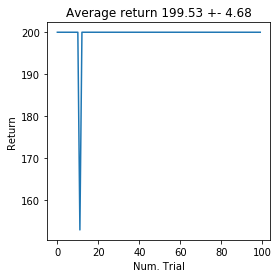

In [10]:
from gym import wrappers

env = gym.make("CartPole-v0")
env = wrappers.Monitor(env, "./gym-results", force=True, video_callable=False)
n_trials = 100
list_rewards = []

for i in range(n_trials):
    observation = env.reset()
    ep_return = 0
    done = False
    while not done:
        action = agent.get_action(observation, n_actions, 0.01)
        observation, reward, done, info = env.step(action.item())
        ep_return += reward
    list_rewards.append(ep_return)
env.close()

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(list_rewards)
ax.set_xlabel("Num. Trial")
ax.set_ylabel("Return")
ax.set_title('Average return %s +- %s' % (np.round(np.mean(list_rewards),2), np.round(np.std(list_rewards), 2)))

### This is an example of the performance obtained after training the agent with the hyper-parameters listed above for a total of 500 episodes.

In [11]:
import io
import base64
from IPython.display import HTML

video = io.open('./Support/images/exampleSolution.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

# Grading

<p style="color:#FF0000";> <b>Important: Set the RUN_TRAINING flag to False before submitting your notebook</b></p> 

You will be graded based on the performance of your network. Your solution will be executed for a total of 100 trials and the average return will be used to determine your grade. The grading scale is:

| Avg. Return | Marks       |
| ----------- | ----------- |
| < 100       | 1  pt       |
| 101 - 120   | 2  pts      |
| 121 - 140   | 3  pts      |
| 141 - 160   | 4  pts      |
| 161 - 180   | 5  pts      |
| > 180       | 6  pts      |

### For your submission:

- Remove all print statements from your code
- Make sure that you do not change the name of the DQN class
- Submit both a copy of your notebook and the trained network. Use the following code to save the parameters of your ``policy`` network.
```python
file_name = "{}_DQN.pt".format(WRITE YOUR STUDENT ID HERE)
torch.save(agent.policy_net.state_dict(), file_name)
```
- Make sure that both your notebook and network file follow the naming convention
- You can tune the hyper-parameters if needed or modify the architecture of the DQN approximator. During grading, we should be able to create a copy of your DQN network using the submitted file without problem.
- To test wether your network has been saved correctly and can be loaded without issue, you can use the code provided below

```python
USE_CUDA = torch.cuda.is_available()
policy = DQN(num_inputs=dim_state, num_actions=n_actions, hidden_dim=hidden_dim)

# Load the parameters you saved into the new instance
if USE_CUDA:
    device = torch.device('cuda')
    policy.load_state_dict(torch.load(file_name))
    policy.to(device)
else:
    device = torch.device('cpu')
    policy.load_state_dict(torch.load(file_name, map_location=device))    

# Set your network in evaluation mode before running inference.
policy.eval()

# Generate test episode
env = gym.make("CartPole-v0")
state = env.reset()

# Set state to device
t_s = torch.tensor(state).float().to(device)

# Sample action
with torch.no_grad():
    q_values = policy(t_s)
q_value, action = torch.max(q_values, axis=0)

print(env.step(action.item()))

```

In [12]:
#file_name = "{}_DQN.pt".format(26932504)
#torch.save(agent.policy_net.state_dict(), file_name)

In [13]:
USE_CUDA = torch.cuda.is_available()
policy = DQN(num_inputs=dim_state, num_actions=n_actions, hidden_dim=hidden_dim)

# Load the parameters you saved into the new instance
if USE_CUDA:
    device = torch.device('cuda')
    policy.load_state_dict(torch.load(file_name))
    policy.to(device)
else:
    device = torch.device('cpu')
    policy.load_state_dict(torch.load(file_name, map_location=device))    

# Set your network in evaluation mode before running inference.
policy.eval()

# Generate test episode
env = gym.make("CartPole-v0")
state = env.reset()

# Set state to device
t_s = torch.tensor(state).float().to(device)

# Sample action
with torch.no_grad():
    q_values = policy(t_s)
q_value, action = torch.max(q_values, axis=0)

#print(env.step(action.item()))

(array([-0.04505668, -0.18766738,  0.01249124,  0.33424327]), 1.0, False, {})
